### Preparing the Environment 

In [2]:
import gym
import numpy as np
import math
from mdp import MDP
from mdp import has_graphviz
from IPython.display import display
print("Graphviz available:", has_graphviz)

Graphviz available: True


In [3]:
pendulumEnv = gym.make('Pendulum-v0')

In [4]:
pendulumEnv.reset()

array([ 0.80270671, -0.59637399, -0.72518987])

### Discretizing the Continuous Observation Space and Action Space

In [5]:
def get_sampled_action_space():
    return np.linspace(-2.0, 2.0, 5).astype(float) 

In [6]:
def get_sampled_theta():
    thetas = np.linspace(-np.pi, np.pi, 8).astype(float)
    thetas = np.insert(thetas, 4, 0)
    return thetas

In [7]:
def get_sampled_thetaDt():
    thetaDts = np.linspace(-8, 8, 16).astype(float)
    thetaDts = np.insert(thetaDts, 8, 0)
    return thetaDts

In [8]:
sampled_action_space = get_sampled_action_space()
sampled_action_space

array([-2., -1.,  0.,  1.,  2.])

In [9]:
sampled_theta = get_sampled_theta() 
sampled_theta

array([-3.14159265, -2.24399475, -1.34639685, -0.44879895,  0.        ,
        0.44879895,  1.34639685,  2.24399475,  3.14159265])

In [10]:
sampled_thetaDt = get_sampled_thetaDt() 
sampled_thetaDt

array([-8.        , -6.93333333, -5.86666667, -4.8       , -3.73333333,
       -2.66666667, -1.6       , -0.53333333,  0.        ,  0.53333333,
        1.6       ,  2.66666667,  3.73333333,  4.8       ,  5.86666667,
        6.93333333,  8.        ])

In [11]:
def get_discretised_states(thetas, thetaDts):
    discretised_states = []
    for vel in thetaDts:
        for theta in thetas:
            discretised_states.append((theta, vel))
    return discretised_states

In [12]:
discretised_pendulum_states = get_discretised_states(sampled_theta, sampled_thetaDt)

### Generating the Transition Probability Matrix

In [13]:
def get_closest_state(state):
    new_theta = state[0]
    new_thetaDt = state[1]
    
    sampled_theta_array = np.asarray(sampled_theta)
    sampled_thetaDt_array = np.asarray(sampled_thetaDt)
    
    closest_theta_index = (np.abs(sampled_theta_array - (new_theta))).argmin()
    closest_thetaDt_index = (np.abs(sampled_thetaDt_array - (new_thetaDt))).argmin()
    
    closest_theta = sampled_theta_array[closest_theta_index]
    closest_thetaDt = sampled_thetaDt_array[closest_thetaDt_index]
    
    return tuple([closest_theta, closest_thetaDt])

In [14]:
def gen_transitions_rewards(states, actions):
    num_states = len(states)
    num_actions = len(actions)

    # Dictionaries necessary for MDP visualisation
    transition_dict = {}
    reward_dict = {}

    # transition probability matrix (num_states x num_states x num_actions)
    transition_matrix = np.zeros([num_states, num_states, num_actions])
    # rewards list
    rewards= np.zeros([num_states])

    for state_index, state in enumerate(states):
        action_reward = {}
        action_transition = {}        

        for action_index, action in enumerate(actions):

            # gets the (x,y), theta_dt and reward based on the action applied on 
            # pendulumEnv which is set to a certain state
            pendulumEnv.state = (state)
            observation, reward, _, _ = pendulumEnv.step([action])
            
            x = observation[0]
            y = observation[1]
            theta_dt = observation[2]

            # retrieves theta based on x and y
            theta = math.atan2(y, x)

            new_state = (theta, theta_dt)

            # get the closest discretised new_state
            closest_state = get_closest_state(new_state)
            new_state_index = states.index(closest_state)
            
            # build the transition_matrix and populate the dicts
            # to be used for diagramming state-transitions
            action_reward[str(action)] = {"S"+str(new_state_index): reward}
            action_transition[str(action)] = {"S"+str(new_state_index): 1}  
            transition_matrix[state_index, new_state_index, action_index] = 1
            rewards[state_index] = reward

        # dicts to be used for digrammming with graphviz
        reward_dict["S"+str(state_index)] = action_reward
        transition_dict["S"+str(state_index)] = action_transition        

    return transition_matrix, rewards, transition_dict, reward_dict

In [15]:
trans_probs, rewards, trans_dict, reward_dict = gen_transitions_rewards(discretised_pendulum_states, sampled_action_space)

### Printing the Transition Probabilities as part of explaination in the Report

In [16]:
trans_probs.shape

(153, 153, 5)

### Visualizing the States and Transition Probabilities

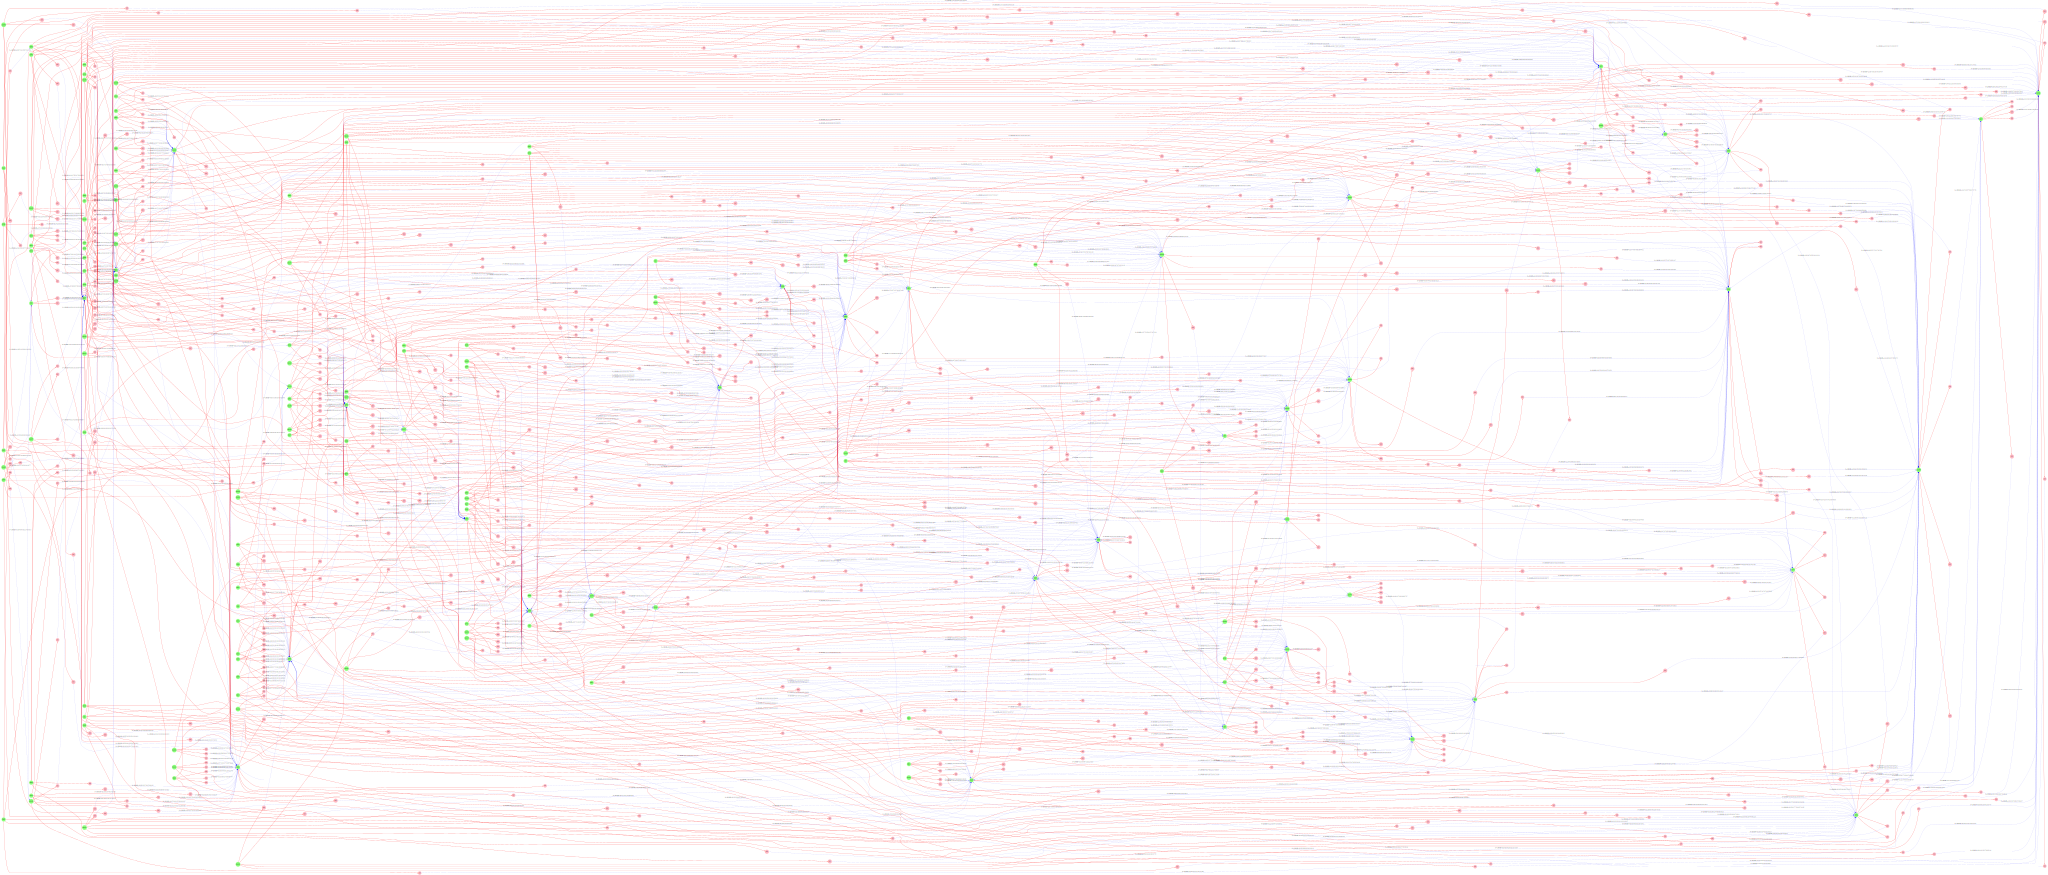

In [18]:
mdp = MDP(trans_dict, reward_dict, initial_state='S0')
if has_graphviz:
    from mdp import plot_graph, plot_graph_with_state_values, plot_graph_optimal_strategy_and_state_values
    diagram = plot_graph(mdp)
    diagram.render(filename='state_transition_1.dot')
    display(diagram)

### Policy Iteration

In [19]:
def policy_eval(policy, value_func, rewards, transition_matrix, gamma, num_states):
    identity_matrix = np.identity(num_states)
    for s_num in range(num_states):
        action = int(policy[s_num])
        value_func[s_num] = np.linalg.solve(identity_matrix - gamma * transition_matrix[:, :, action], rewards) [s_num]
    return value_func

In [25]:
def get_expected_action(value_function, transition_matrix, starting_vector, num_actions):
    actions_array = np.zeros(num_actions)
    for action in range(num_actions):
        actions_array[action] = np.sum(np.multiply(value_function, np.dot(starting_vector, transition_matrix[:,:,action])))
    return np.argmax(actions_array)

In [21]:
def get_initial_policy(action_num, state_num, actions):
    policy = np.random.randint(0, action_num, size=(state_num))
    for index in range(state_num):
        random_index = policy[index]
        policy[index] = actions[random_index]
    policy = policy.astype(np.float32)
    return policy

In [22]:
test_policy = get_initial_policy(len(sampled_action_space), len(discretised_pendulum_states), sampled_action_space)
print(test_policy)

[-1. -1.  1.  2.  1.  2. -2.  2.  1. -1.  0. -1. -2.  0.  1.  2.  0.  2.
  0.  0.  2.  0.  2. -2. -1.  0.  1. -2. -1.  0. -2.  1.  2.  0. -2.  2.
  0. -1. -1. -2.  2. -1. -1.  0.  1.  2.  2. -1. -1.  1. -2.  2. -1. -2.
 -2. -2.  2. -2. -1.  2. -1.  1.  2.  2. -2. -1.  1. -2. -1.  0.  2. -1.
  0.  2.  1. -1.  1. -1.  1.  0.  1.  1.  2. -2. -1.  2.  0.  1.  1.  0.
  1. -2.  0. -1. -2.  1. -1. -2. -1.  2.  1.  2. -2.  0.  2.  1. -2. -1.
 -1.  0.  0. -2.  0.  1.  1.  0. -2. -1. -1.  2. -2. -1.  0.  0. -2. -2.
  0. -1.  0.  2.  1. -2.  2.  1.  2.  0.  0.  0.  2. -2.  1.  1.  2.  0.
  2. -2. -1. -1. -2. -2. -2.  2.  2.]


In [34]:
def exact_policy_iteration(actions, states, transition_matrix, rewards, gamma):
    
    iteration = 0
    action_num = len(actions)
    state_num = len(states)
    policy = get_initial_policy(action_num, state_num, actions)
    value_func = np.zeros(state_num)
    threshold = 0.001
    
    while True:
        iteration += 1
        value_func_last = value_func.copy()
        
        # Policy Evaluation
        value_func = policy_eval(policy, value_func, rewards, transition_matrix, gamma, state_num)
        
        delta = np.absolute(value_func - value_func_last).max()
        if delta < threshold:
            break
        
        # Policy Improvement
        for s in range(state_num):
            starting_vector = np.zeros((1, state_num))
            starting_vector[0, s] = 1.0
            expected_action = get_expected_action(value_func, transition_matrix, starting_vector, action_num)
            if expected_action != policy[s]: 
                policy[s] = expected_action

        
        print("Iteration:", iteration, ", delta", delta)        
        
    return policy

In [35]:
gamma = 0.90
optimal_policy = exact_policy_iteration(sampled_action_space, discretised_pendulum_states, trans_probs, rewards, gamma)

Iteration: 1 , delta 76.86716652564718
Iteration: 2 , delta 57.33615518601173
Iteration: 3 , delta 54.93435665370699
Iteration: 4 , delta 37.69290477976897
Iteration: 5 , delta 32.54298577077546
Iteration: 6 , delta 22.23734238467975


In [37]:
np.save("pendulum_v0_optimal_policy_1", optimal_policy)

### Average Reward Result over 1000 timesteps

In [38]:
def get_action(state, policy, states, actions):
    state_index = states.index(state)
    action = int(policy[state_index])
    optimal_action = actions[action]
    return optimal_action

In [39]:
total_reward = 0
num_episodes = 5 
max_time_steps = 200 # episode truncation
counter = 0
pendulum = gym.make('Pendulum-v0')

for episode in range(0, num_episodes):
    obs = pendulum.reset()
    done = False
    episodic_reward = 0

    for ts in range(0, max_time_steps):
        counter += 1

        # action for the given observation in the PendulumEnv
        action = get_action(get_closest_state([obs[0], obs[1]]), 
                                    optimal_policy, discretised_pendulum_states, sampled_action_space)

        
        actions = np.ndarray(1,)
        actions[0] = action
        obs, reward, done, _ = pendulum.step(actions)
        
        episodic_reward += reward
        
        if done:
            print("episode {}: reward in this episode: {}".format(episode, episodic_reward))
            print("---------------------------------------------------------------")
            total_reward += episodic_reward
            break
print("")
print("Iterations:", counter)
print("total reward for", counter, "timesteps =", total_reward)
print("average reward per", counter, "timesteps =", total_reward / counter)

episode 0: reward in this episode: -1632.587548100858
---------------------------------------------------------------
episode 1: reward in this episode: -923.7309404358839
---------------------------------------------------------------
episode 2: reward in this episode: -1142.7188411801287
---------------------------------------------------------------
episode 3: reward in this episode: -1013.015090412486
---------------------------------------------------------------
episode 4: reward in this episode: -1540.1090721741768
---------------------------------------------------------------

Iterations: 1000
total reward for 1000 timesteps = -6252.161492303533
average reward per 1000 timesteps = -6.252161492303533
